# Read the files

In [223]:
library("tidyverse")
library("janitor")

In [224]:
df_train = readRDS("df_train.RData")

In [225]:
head(df_train)

t_date,t_yr,t_mo,t_day,t_qtr,t_wk,t_day_of_yr,t_day_of_wk,t_day_of_wk_name,t_eval_day,⋯,wea_ohare_tavg2_ma60_lag14,wea_ohare_tavg2_ma60_lag21,wea_ohare_tavg2_ma60_lag28,wea_ohare_tavg2_ma60_lag35,wea_ohare_tavg2_ma60_lag42,wea_ohare_tavg2_ma60_lag49,wea_ohare_tavg2_ma60_lag56,wea_ohare_tavg2_ma60_lag63,wea_ohare_tavg2_ma60_lag90,wea_ohare_tavg2_ma60_lag120
2007-05-29,2007,5,29,2,22,149,2,Mon,514,⋯,51.00833,48.725,44.69167,42.1,38.61667,35.55,31.775,27.80833,23.83333,31.73333
2007-05-29,2007,5,29,2,22,149,2,Mon,514,⋯,51.00833,48.725,44.69167,42.1,38.61667,35.55,31.775,27.80833,23.83333,31.73333
2007-05-29,2007,5,29,2,22,149,2,Mon,514,⋯,51.00833,48.725,44.69167,42.1,38.61667,35.55,31.775,27.80833,23.83333,31.73333
2007-05-29,2007,5,29,2,22,149,2,Mon,514,⋯,51.00833,48.725,44.69167,42.1,38.61667,35.55,31.775,27.80833,23.83333,31.73333
2007-05-29,2007,5,29,2,22,149,2,Mon,514,⋯,51.00833,48.725,44.69167,42.1,38.61667,35.55,31.775,27.80833,23.83333,31.73333
2007-05-29,2007,5,29,2,22,149,2,Mon,514,⋯,51.00833,48.725,44.69167,42.1,38.61667,35.55,31.775,27.80833,23.83333,31.73333


In [226]:
glimpse(df_train)

Observations: 8,222
Variables: 113
$ t_date                             <date> 2007-05-29, 2007-05-29, 2007-05...
$ t_yr                               <int> 2007, 2007, 2007, 2007, 2007, 20...
$ t_mo                               <int> 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,...
$ t_day                              <int> 29, 29, 29, 29, 29, 29, 29, 29, ...
$ t_qtr                              <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,...
$ t_wk                               <int> 22, 22, 22, 22, 22, 22, 22, 22, ...
$ t_day_of_yr                        <int> 149, 149, 149, 149, 149, 149, 14...
$ t_day_of_wk                        <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,...
$ t_day_of_wk_name                   <chr> "Mon", "Mon", "Mon", "Mon", "Mon...
$ t_eval_day                         <int> 514, 514, 514, 514, 514, 514, 51...
$ t_eval_wk                          <int> 74, 74, 74, 74, 74, 74, 74, 74, ...
$ trap_trap_name                     <chr> "T002", "T007", "T015", "T045", ...
$ loc_lat        

## Keep only few weather columns

In [227]:
keep_weather_cols = function(df){
    message("... Keeping few weather columns")
    df_other_cols = df %>% select(-starts_with("wea_"))
    df_wea = df %>% select("wea_ohare_tmax","wea_ohare_prcp","wea_ohare_prcp_sum7",
                  "wea_ohare_tavg2","wea_ohare_tavg2_ma7","wea_ohare_tavg2_ma60_lag7")
    df_other_cols %>% bind_cols(df_wea)
}

## Add custom lag vars

## Add WOE Features

Calculating the Weight Of Evidence (WOE) and Informational Value (IV) to perform a quick univariate evaluation of which features can be important for the classification problem at hand.

Readings for reference: [Link 1](http://r-statistics.co/Information-Value-With-R.html) , [Link 2](https://multithreaded.stitchfix.com/blog/2015/08/13/weight-of-evidence/)

In [251]:
library("InformationValue")

In [252]:
df_train %>% select_if(is_character) %>%
    map_df(~as.factor(.x)) %T>%
    print(head()) %>%
    purrr::map_dbl(~IV(., df_train$mos_any_wnv_present)) -> iv_1

df_train %>% select_if(is.factor) %T>%
    print(head()) %>%
    purrr::map_dbl(~IV(., df_train$mos_any_wnv_present)) -> iv_2

# A tibble: 8,222 x 6
   t_day_of_wk_name trap_trap_name loc_lat_lng_src loc_community zone_class
   <fct>            <fct>          <fct>           <fct>         <fct>     
 1 Mon              T002           CDPH            DUNNING       RS-2      
 2 Mon              T007           CDPH            FOREST GLEN   POS-1     
 3 Mon              T015           CDPH            NORWOOD PARK  RS-2      
 4 Mon              T045           CDPH            LINCOLN PARK  PD 1031   
 5 Mon              T046           CDPH            HUMBOLDT PARK PMD 4     
 6 Mon              T048           CDPH            NEAR WEST SI… PD 896    
 7 Mon              T049           CDPH            WEST TOWN     C1-3      
 8 Mon              T050           CDPH            LOGAN SQUARE  RS-3      
 9 Mon              T054           CDPH            LINCOLN PARK  POS-1     
10 Mon              T086           CDPH            MORGAN PARK   RS-1      
# ... with 8,212 more rows, and 1 more variable: trap_trap_type <f

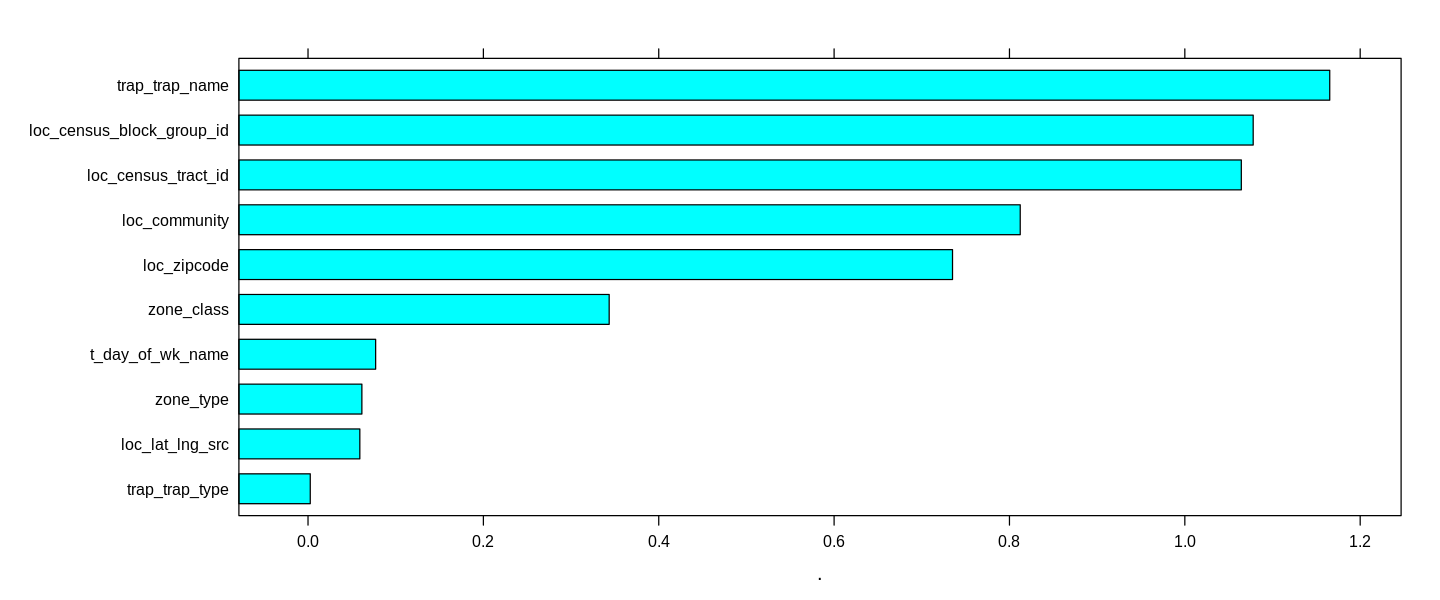

In [256]:
c(iv_1, iv_2) %>% sort() %>% barchart()

This chart tells us that the most important features (among the factor & character features) which add value for classification are trap name, census block group id, tract id, community, zipcode and class. On the other hand, week name, zone type, lat-long source and trap type have little to no predictive power {on their own}. 

Diving deeper into each key variable, it's possible to see which levels have the highest contribution towards differentiation of the two classes. We can do this using the WOE calculation.

#### Clearly, there are some traps, zones, regions waay more predictive that others.

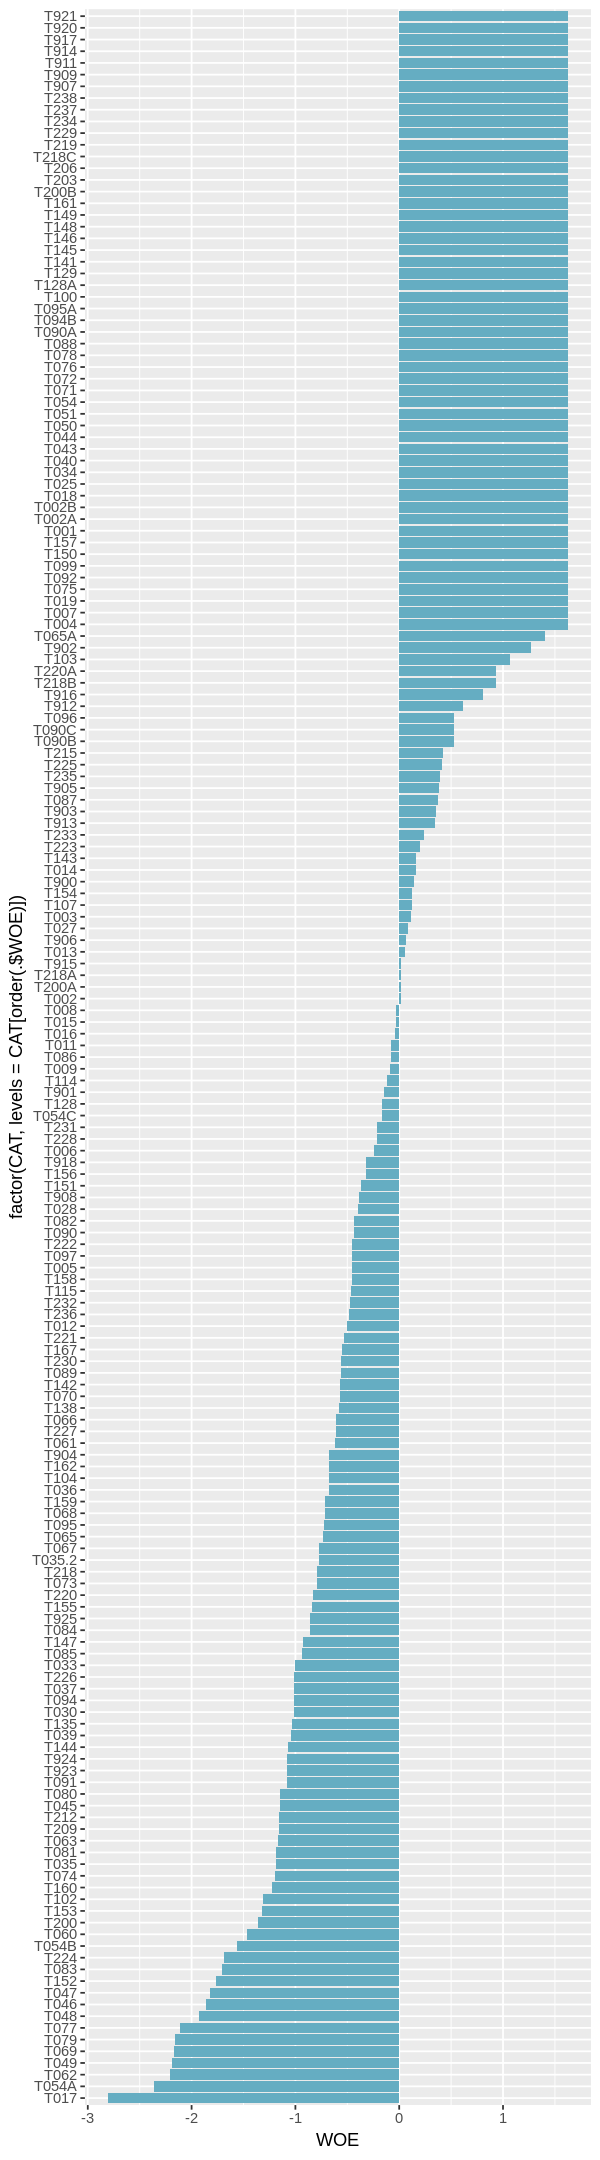

In [277]:
options(repr.plot.width=5, repr.plot.height=18)
WOETable(as.factor(df_train$trap_trap_name), df_train$mos_any_wnv_present,valueOfGood = 1) %>% 
    arrange(WOE) %>%
    ggplot(aes(factor(CAT,levels=CAT[order(.$WOE)]),WOE)) + geom_col() + coord_flip()

Warning message:
“Removed 4 rows containing missing values (position_stack).”

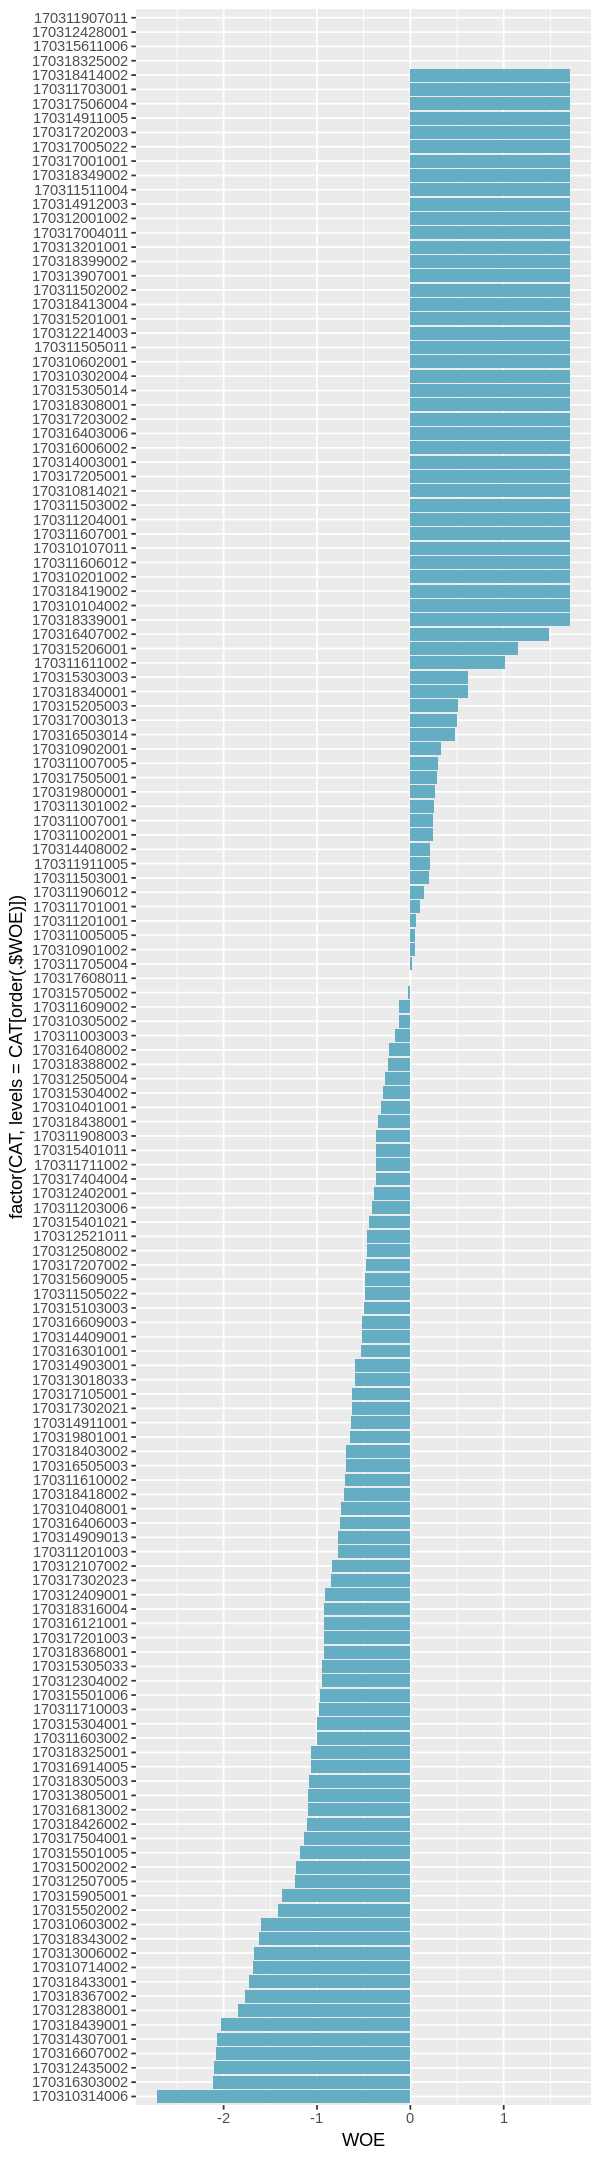

In [278]:
options(repr.plot.width=5, repr.plot.height=18)
WOETable(as.factor(df_train$loc_census_block_group_id), df_train$mos_any_wnv_present,valueOfGood = 1) %>% 
    arrange(WOE) %>%
    ggplot(aes(factor(CAT,levels=CAT[order(.$WOE)]),WOE)) + geom_col() + coord_flip()

Warning message:
“Removed 3 rows containing missing values (position_stack).”

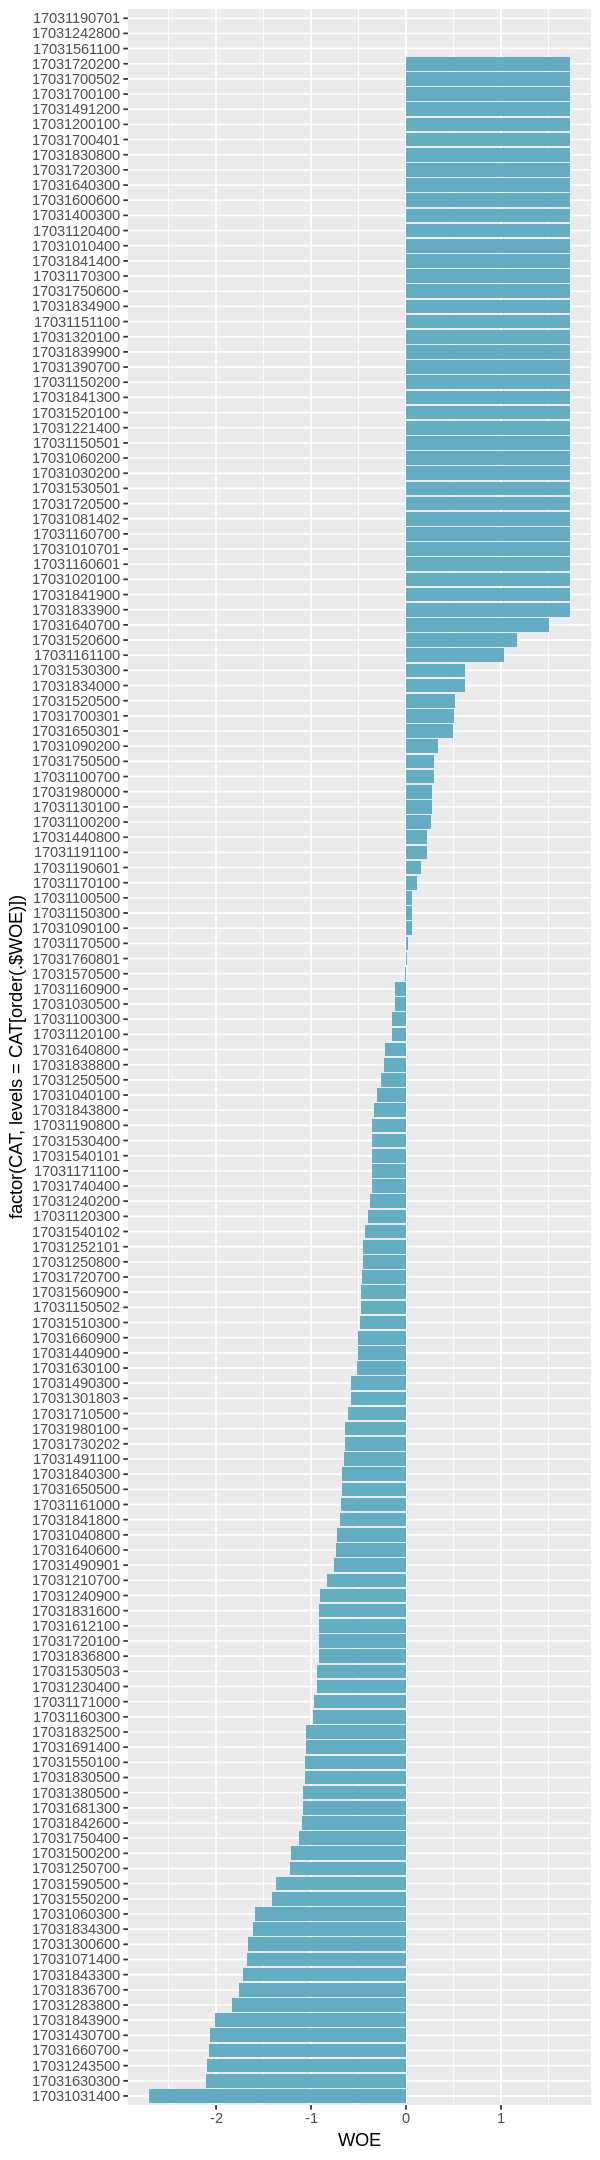

In [280]:
options(repr.plot.width=5, repr.plot.height=18)
WOETable(as.factor(df_train$loc_census_tract_id), df_train$mos_any_wnv_present,valueOfGood = 1) %>% 
    arrange(WOE) %>%
    ggplot(aes(factor(CAT,levels=CAT[order(.$WOE)]),WOE)) + geom_col() + coord_flip()

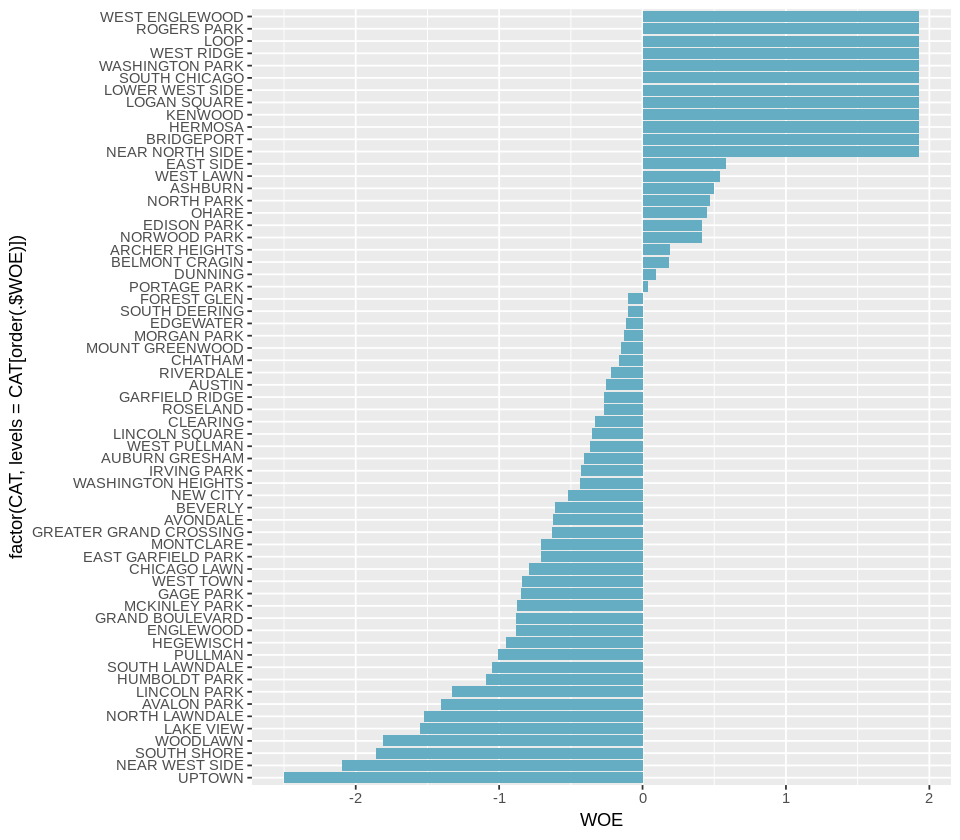

In [285]:
options(repr.plot.width=8, repr.plot.height=7)
WOETable(as.factor(df_train$loc_community), df_train$mos_any_wnv_present,valueOfGood = 1) %>% 
    arrange(WOE) %>%
    ggplot(aes(factor(CAT,levels=CAT[order(.$WOE)]),WOE)) + geom_col() + coord_flip()

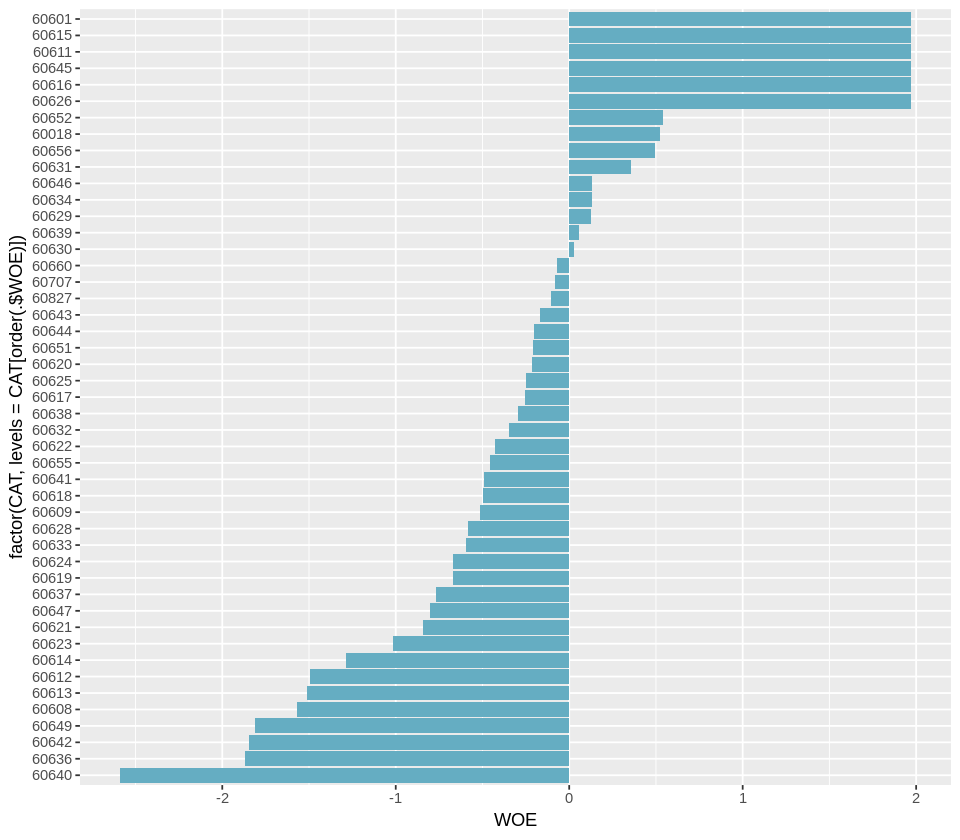

In [287]:
options(repr.plot.width=8, repr.plot.height=7)
WOETable(as.factor(df_train$loc_zipcode), df_train$mos_any_wnv_present,valueOfGood = 1) %>% 
    arrange(WOE) %>%
    ggplot(aes(factor(CAT,levels=CAT[order(.$WOE)]),WOE)) + geom_col() + coord_flip()

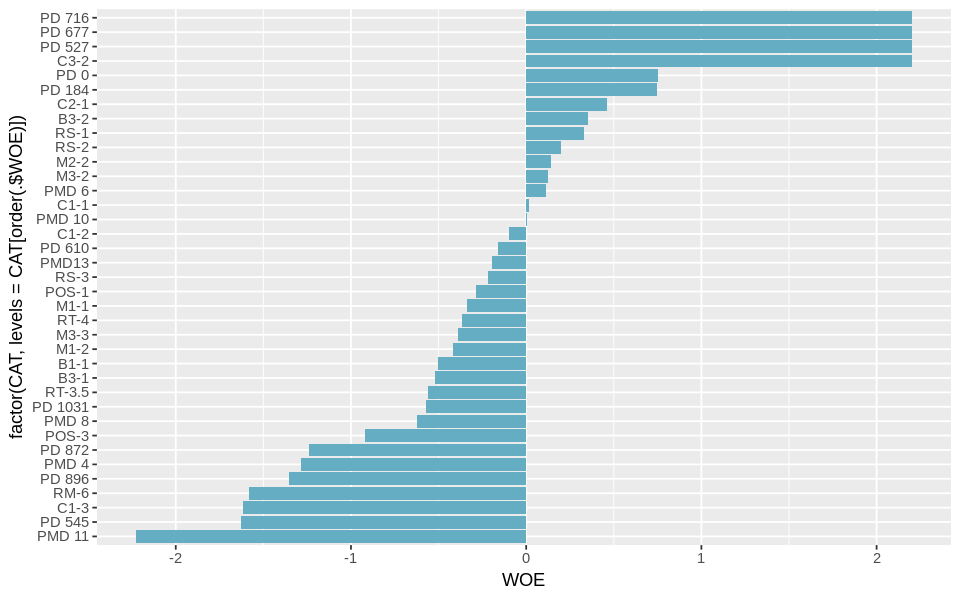

In [289]:
options(repr.plot.width=8, repr.plot.height=5)
WOETable(as.factor(df_train$zone_class), df_train$mos_any_wnv_present,valueOfGood = 1) %>% 
    arrange(WOE) %>%
    ggplot(aes(factor(CAT,levels=CAT[order(.$WOE)]),WOE)) + geom_col() + coord_flip()

## Convert certain cols to factors

## Time related features

ERROR: Error in parse(text = x, srcfile = src): <text>:1:8: unexpected symbol
1: !conda install
           ^
